## Случайный лес. Random Forest.

In [32]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('../data/bank.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [34]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [35]:
df.loc[df['Tenure'].isna(),'Tenure'] = df['Tenure'].median()
df['Gender']=df['Gender'].map({'Female':0, 'Male':1})
df_dummies = pd.get_dummies(df['Geography'])
df.drop(columns=['RowNumber','CustomerId','Surname','Geography'], inplace=True)
df = pd.concat([df, df_dummies],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


In [36]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
parameters = {'min_samples_leaf':range(1,8,2), 'max_features':[4,6,8]}
rfc = RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators=100, max_depth = 12)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, return_train_score=True)
gcv.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(max_depth=12, n_jobs=-1,
                                              random_state=10),
             n_jobs=-1,
             param_grid={'max_features': [4, 6, 8],
                         'min_samples_leaf': range(1, 8, 2)},
             return_train_score=True)

In [39]:
gcv.best_score_, gcv.best_params_

(0.8664999999999999, {'max_features': 4, 'min_samples_leaf': 1})

## Метрика

In [40]:
rfc = RandomForestClassifier(random_state=10, n_jobs=-1)
df['pred']=rfc.fit(X[:1000],y[:1000]).predict(X)
df[['Exited','pred']][-10:]

,Exited,pred
9990,0,0
9991,1,1
9992,0,0
9993,0,0
9994,0,0
9995,0,0
9996,0,0
9997,1,0
9998,1,0
9999,0,0


In [41]:
y_valid = df['Exited'][-10:]
y_pred = df['pred'][-10:]

In [42]:
metrics.accuracy_score(y_valid,y_pred)

0.8

![](https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg)

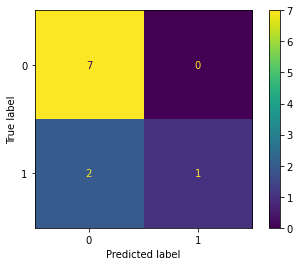

In [43]:
cm = metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()

## Precision и Recall

$$precision = \frac{TP}{TP + FP}\quad$$
$$recall = TPR = \frac{TP}{TP + FN}\quad$$ 

In [44]:
precision = metrics.precision_score(y_valid,y_pred)
recall = metrics.recall_score(y_valid,y_pred)

precision, recall

(1.0, 0.3333333333333333)

In [45]:
metrics.f1_score(y_valid,y_pred)

0.5

## ROC AUC

In [46]:
y_proba = rfc.predict_proba(X)
df[['false_pred','true_pred']] = y_proba
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,pred,false_pred,true_pred
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0.26,0.74
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,0,0.91,0.09
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0.05,0.95
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,0,0.90,0.10
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,0,0.97,0.03


In [47]:
df[['Exited','true_pred']][-10:].sort_values(by='true_pred',ascending=False)

,Exited,true_pred
9991,1,0.73
9998,1,0.22
9990,0,0.20
9992,0,0.18
9999,0,0.14
9993,0,0.10
9994,0,0.06
9995,0,0.04
9997,1,0.03
9996,0,0.00


![](https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png)

$$recall = TPR = \frac{TP}{TP + FN}\quad$$ 
$$FPR = \frac{FP}{FP + TN}\quad$$ 

In [ ]:
metrics.plot_roc_curve(rfc, X[-10:], y[-10:])

🛠 Построить модель случайного леса для датасета выживших на Титанике, сравнить метрики accuracy, precision, recall, f1 с домашним заданием из 3 лекции. Отобразить roc auc.

In [ ]:
df = pd.read_csv('../data/titanic.csv')
y=df['survived']
df.head()
# Ваш код здесь